# Numeric Representation of Text


## Imports


In [1]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from sklearn.manifold import TSNE
import json
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

## 1. Test with 5 data


In [ ]:
# Configuración del modelo y tokenizer BERT
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Función para obtener el embedding de un texto
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    # Usamos el embedding del token [CLS]
    cls_embedding = outputs.last_hidden_state[0, 0, :].detach().numpy()
    return cls_embedding

# Lista de textos de ejemplo - 5 datos
texts = [
    "El 9 de septiembre pasado, con cinco votos a favor, ninguno en contra y siete abstenciones, la Comisión de Principios y Derechos Civiles y Políticos del Consejo Constitucional rechazó la Iniciativa Popular de Norma N.º 9.247: “Niños, Niñas y Adolescentes en la Nueva Constitución”. \nTras esto Fernando Viveros, uno de los exconsejeros que votó a favor, dio a entender que con este resultado los derechos de niños, niñas y adolescentes (NNA) quedaron fuera del borrador del nuevo texto constitucional. A través de fuentes expertas y la revisión de los artículos de la propuesta de nueva Constitución, el Equipo de FactChecking.cl determinó que la afirmación es falsa. \nDicha Iniciativa Popular de Norma, que alcanzó a reunir un total de 11.159 firmas, pretendía incluir en la propuesta de nueva Constitución lo siguiente:  \n«La Constitución reconoce y asegura los derechos de los niños, niñas y adolescentes. El Estado promoverrá la protección integral de la niñez adoptando, sin discriminación, medidas para resguardar su supervivencia y desarrollo».\nSin embargo, en la propuesta del texto constitucional que será llevada a plebiscito, dice en el artículo 12: «La Constitución reconoce y asegura el interés superior de los niños, el cual incluye las condiciones para crecer y desarrollarse en su familia. Se entiende por niño todo ser humano menor de dieciocho años de edad». \nLos derechos de NNA siguen presentes \nReferente a la afirmación hecha por Viveros, Álvaro Paúl, director de la Revista Chilena de Derecho, aseguró: “Decir que los derechos de los niños quedaron fuera de la Constitución no es cierto. El solo hecho de que no se haya aprobado una norma que se refería explícitamente a ‘los derechos de los niños niñas y adolescentes’ no basta para afirmar lo anterior”. \nPaúl agregó que en el capítulo II (Art. 16) del texto propuesto se garantizan los derechos a todas las personas, incluyendo a NNA. Lo que significa que sus derechos están resguardados al igual que los de todos los demás. \nPor su parte Alberto Vergara, Master of Law de la Universidad Northwestern, quien imparte el curso “Derechos Fundamentales y Derechos Humanos” en la Pontificia Universidad Católica de Chile hace referencia al artículo 3 de la propuesta constitucional para afirmar que lo publicado por Viveros no es efectivo.  \nDicho artículo dice lo siguiente: \n«Las normas de derecho interno deberán interpretarse de forma compatible con la Constitución, y considerando las disposiciones referidas a derechos y libertades de los tratados de derechos humanos ratificados por Chile y que se encuentran vigentes. Se distinguirán las disposiciones de dichos tratados a otros instrumentos internacionales que puedan asistir a los Estados en su comprensión y aplicación, pero que no tienen carácter jurídicamente vinculante».  \nSobre las normas de derecho interno a las que se refiere el artículo, Vergara señala que estas “deberán interpretarse considerando las disposiciones de los tratados de derechos humanos ratificados por Chile y que se encuentren vigentes, y entre dichos tratados, se encuentran tanto la Convención de las Naciones Unidas sobre los Derechos del Niño, como varios de sus Protocolos Facultativos y Enmiendas, que han sido suscritos y ratificados por Chile”. Nuestro país ratificó dicho tratado en 1990, a través de un Decreto Aprobatorio el 27 de septiembre de ese año. \nTeniendo en cuenta lo desarrollado con anterioridad al consultar fuentes documentales y expertas, el Equipo de FactChecking.cl determinó que la afirmación es “falsa”. A pesar de que la propuesta de nueva Constitución no haga referencia explicita a NNA, no significa que sus derechos han sido excluidos tras el rechazo de la Iniciativa Popular de Norma N.º 9.247. \n\nRelacionado",
    "El 25 de noviembre de 2023, durante la franja oficial del Consejo Nacional de Televisión (CNTV), específicamente en la opción a favor de la nueva Carta Magna, la concejala de Renca y vicepresidenta del Partido Demócratas, Camila Avilés, habló sobre el sistema de salud en la nueva propuesta constitucional. La autoridad comunal aseguró que la propuesta de nueva constitución establecerá un sistema único de salud que no discrimine.  \nLa concejala Avilés, especificó al Equipo de FactChecking.cl que “el sistema de salud discrimina por género, preexistencias y también por edad, sobre todo a las mujeres, porque a ellas se les cobra más por ser mujeres en edad fértil. Hoy día podría tener rango constitucional, el tener que crear un sistema universal de salud que permita que todos y todas puedan acceder, y con eso cubrir los costos en salud sin ningún tipo de diferencia entre personas”. \nEl Equipo de FactChecking.cl revisó la nueva propuesta constitucional, y consultó a expertos del área de la salud concluyendo que la afirmación dicha por la concejala es verdadera. \nEl sistema de salud universal está en la propuesta de Constitución \nDe acuerdo al texto aprobado por el Consejo Constitucional, se dice explícitamente en el artículo 16, inciso 22, letra c, que “la ley establecerá un plan de salud universal”. Por lo tanto, el documento asegura textualmente los dichos de Avilés. \nEn la actualidad existe un proyecto de plan universal de salud, que es un fondo compensatorio de carácter público y solo aplica para el Fondo Nacional de Salud (Fonasa), a diferencia de la nueva propuesta constitucional, que incluye tanto a esta como a Instituciones de Salud Previsional (Isapre).  \nEl proyecto se encuentra en su primer trámite constitucional en el Senado y, según el Ministerio de Salud (Minsal), “esta iniciativa garantizará el acceso a la atención oportuna, de calidad y con protección financiera, permitirá que todas las personas tengan el mismo plan de salud (…) sin discriminar por edad, género, nivel de ingreso o condición de salud. Además, se establecen tiempos máximos de atención para cirugías y consultas médicas de especialidad de enfermedades No AUGE”.  \nPara hacer un análisis del tema, el Equipo de FactChecking.cl se contactó con el abogado constitucionalista de la Universidad de Chile, Andrés Sepúlveda, quien aseguró, que al implementar un plan de salud universal “es básicamente lo mismo que tenemos ahora, solamente que hay muchas normas de rango legal que han sido subidas a materia constitucional, pero no hay un compromiso del Estado en la generación de más recursos para asegurar la salud”. \nLa idea anterior no es compartida por la abogada y jefa del Departamento Jurídico en Servicio de Salud Pública Atacama, María Teresa Hola, quien mencionó que este plan robustece el derecho a la salud y vuelve más equitativo al sistema, lo que tiene como consecuencia la eliminación de diferencias que muchas veces resultan arbitrarias. \n“En cuanto a la creación de un plan de salud universal, sin duda genera un impacto positivo en la persona, por cuanto es una garantía constitucional transversal que obliga tanto al Estado como a instituciones privadas a no ejercer discriminación o condicionar las prestaciones a una preexistencia”, afirmó Hola. \nSe garantizaría la no discriminación, pero falta claridad en el funcionamiento del sistema \nEn sus declaraciones, Camila Avilés aseguró que existirá no existiría discriminación en este sistema. Frente a esta parte de la afirmación, el Equipo de FactChecking.cl revisó la nueva propuesta constitucional de la fecha, donde en el artículo 16, inciso 22, letra c, se explica que se “establecerá un plan de salud universal, sin discriminación por edad, sexo o preexistencia médica, el cual será ofrecido por instituciones estatales y privadas”. \nPor lo tanto, según el texto, se nombra explícitamente que el plan universal de salud no discriminará por las preexistencias médicas, la edad y el sexo. Sin embargo, más allá de la discriminación, esto tiene implicancias en lo que respecta al funcionamiento de las instituciones públicas y privadas.  \nEn esta línea, el doctor en Salud Pública y docente de la Universidad de Chile, Marcos Vergara, sostuvo en una conversación con el Equipo de FactChecking.cl que en relación a la discriminación, él opina que efectivamente existe una segmentación tarifaria debido a enfermedades preexistentes, mujeres en edad fértil y personas de edad avanzada, ya que esto implica un mayor costo para las aseguradoras. Por lo que los cobros son mayores e implican riesgos de pérdida de dinero para las empresas.  \n“La edad y el género son usados habitualmente para predecir el riesgo por las compañías de seguros de salud. Después están las preexistencias, que son enfermedades que ya existen. Luego ya cabría escarbar en antecedentes clínicos, de los cuales saben las compañías producto de programas médicos y reembolsos. Pero el tema está clausurado con la garantía de acceso universal a un seguro de salud donde las compañías no puedan tarificar por riesgo y quedarían invalidadas en la propuesta de nueva Constitución”, declaró Vergara.  \nAsimismo, el docente afirmó que al implementar un plan de salud universal sin discriminación en la propuesta constitucional, tendría que incluirse la Modalidad de Atención Institucional (MAI) de la red pública, que según la Superintendencia de Salud es donde “las prestaciones médicas se otorgarán a los beneficiarios por los organismos que integran el Sistema Nacional de Servicios de Salud, sean dependientes del Minsal o entidades públicas o privadas con las cuales los Servicios de Salud o el Fondo hayan celebrado convenios para estos efectos”. Sin embargo, esto no se asegura de manera explícita en la propuesta de Carta Magna que se votará el 17 de diciembre.  \nPor su parte, y en la misma línea que el doctor Vergara, el director del Instituto de Salud Pública de la Universidad Andrés Bello (UNAB) y ex superintendente de Isapre, Héctor Sánchez, declaró que al tener un sistema de salud universal que no discrimina por edad, preexistencias y género, no es sinónimo de una mejora en el sistema público. La existencia de este proyecto no garantiza un progreso en la calidad del servicio.  \n “Estas dimensiones dependen de factores estructurales, de la organización de sus modelos de atención y producción, de la eficiencia y de los incentivos que existan para mejorar la calidad y productividad. Por lo tanto, si el país junto a la nueva Constitución no avanza en reformas estructurales del sistema público, la calidad de este y su productividad para reducir las listas de espera no se resolverán”, aclaró Sánchez. \n Tras la investigación realizada por el Equipo de FactChecking.cl, se concluye que la afirmación de la concejala Camila Avilés sobre el sistema de salud es verdadera, ya que la revisión del documento de la propuesta constitucional expresa explícitamente que existirá un seguro universal de salud que no discrimina por preexistencia, edad ni género. Sin embargo, según los expertos y expertas consultados, esto no significa, por si mismo, una mejora en los sistemas de atención de salud.  \n\nRelacionado",
    "En redes sociales se pueden detectar diferentes afirmaciones las cuales esbozan que, de aprobarse el proyecto de nueva Constitución el próximo 17 de diciembre, muchas leyes del Estado chileno quedarían sin efecto. Asimismo, usuarios de internet, aseguran que otras tendrían que ser redefinidas, ajustadas y/o reemplazadas.  \nJoaquín Scheel, usuario de Facebook que suele comentar sobre política y de tendencia de derecha, aseguró a través de su perfil de Facebook el 10 de octubre de 2023 que – sobre el proyecto de nueva Constitución- “cerca de 24.000 leyes actuales quedan caducas y obliga a redefinir nuevas leyes”. Esta frase es falsa, ya que los datos dichos por el usuario no se condicen con la realidad y las consecuencias, según documentos oficiales y el análisis de expertos en el tema, tampoco corresponderían.  \nEl Equipo de FactChecking.cl revisó la página web de la Biblioteca del Congreso Nacional (BCN) de Chile (BCN), donde se encontró un apartado con las últimas leyes publicadas. Allí, con fecha 24 de octubre 2023, se encuentra la ley numerada en 21.625, lo cual da cuenta de la cantidad total de leyes hasta dicha fecha. Por lo tanto, el número que dice Scheel supera por 2.375 leyes a las que realmente existen en Chile. \nEn cuanto a la redefinición de que “las leyes actuales quedan caducadas y obliga a redefinir nuevas leyes”, el Equipo de Factchecking.cl buscó información al respecto en el proyecto de la nueva Constitución. El documento indica en su disposición segunda transitoria, en su numeral dos, que “toda normativa vigente a la fecha de publicación esta Constitución seguirá en vigor mientras no sea derogada, modificada o sustituida, o bien, mientras no sea declarada contraria a la Constitución por el Tribunal Constitucional, en los casos que procesa y de acuerdo a lo establecido en esta Constitución”.  \nPor lo tanto, de aprobarse el proyecto, no existe escenario en el que la totalidad de las leyes se vea afectada por la propuesta. Sin embargo, existen salvedades que podrían verse modificadas en términos legislativos como –por ejemplo- en cuanto a leyes orgánicas, las cuales se abordarán con mayor profundidad en los siguientes párrafos. \nDiversas visiones sobre la modificación de leyes \nPara tener un análisis más completo del tema y comprobar la posibilidad de que cambien todas las leyes con una nueva Constitución, el Equipo de Factchecking.cl consultó a expertos constitucionalistas, quienes dieron cuenta de manera unánime que no es posible que esta propuesta pueda dejar caducas la totalidad de las leyes chilenas.  \nEl académico de Derecho Constitucional de la Universidad Católica (UC), Arturo Fermandois, aclara: “La entrada de la nueva Constitución no produce un descalabro de leyes por derogación inmediata, sino que continuaran en vigencia la generalidad de las leyes”. \nPor su parte, el abogado académico de la Universidad Diego Portales (UDP) especialista en el área constitucional, Gaspar Jenkins, explica que lo que ocurriría tras una posible aprobación de la propuesta constitucional sería lo que se llama una inconstitucionalidad sobrevenida, lo que no afecta a todas las leyes del país.  \n“De aprobarse la constitución no significa que todas las leyes que existen en nuestro país se vuelven inconstitucionales. No. Lo que ocurre es que algunas leyes que pueden ser más sensibles que otras, puedan empezar a tener una contradicción con el texto constitucional, eso en términos técnicos se llama una inconstitucionalidad sobrevenida”, dice Jenkins. \nAsimismo, el abogado constitucionalista de la Universidad Chile, Andrés Sepúlveda, esclarece que hacer un cambio en la totalidad de las leyes sería una exageración. Al respecto, detalla: “Sí, la nueva Constitución va a producir muchísimos cambios normativos, muchas normas que estaban en rangos reglamentarios o legales suben de jerarquía y pasan a completar el firmamento de las normas constitucionales que son bastante numerosas”.  \nTomando en cuenta el análisis de los expertos en el tema y los documentos oficiales que acreditan la cantidad de leyes que existen y las consecuencias que tendría una nueva Carta Magna sobre estas, se puede vislumbrar que la afirmación hecha por el usuario, Joaquín Scheel, es falsa.  \nLas leyes orgánicas sí podrían ser modificadas \nEn la misma línea, el Equipo de Factchecking.cl detectó una declaración de la exconvencional  constituyente Teresa Marinovic, independiente por cupo del Partido Republicano, en la cual afirma que “la aprobación de un nuevo texto constitucional involucra también la adecuación, ajuste o reemplazo de múltiples leyes orgánicas constitucionales o ‘leyes institucionales’ que regulan aspectos tan importantes como el Banco Central, el Poder Judicial, la Contraloría General de la República, el Servicio Electoral, el Tribunal Constitucional, las Fuerzas de Orden y Seguridad Pública, las Fuerzas Armadas”. \nEsta afirmación es verdadera, ya que –aunque la Constitución misma no cambiará las leyes- sí afecta en las condiciones en las que se ejercen, especialmente en materia de leyes orgánicas.  \nUna ley orgánica constitucional, como lo define BCN, “establece los aspectos fundamentales del orden constitucional, incluyendo el establecimiento de instituciones como los tribunales o poder legislativo y, en algunas jurisdicciones, se les otorga estatus similar al de la propia Constitución”. Por lo tanto, una ley orgánica se encarga de regular aspectos fundamentales de la organización de un Estado y “establecerán normas básicas para la organización de las Fuerzas de Orden y Seguridad Pública” (Artículo 117 N°4).  \nLas leyes actuales “deben ser objeto de leyes institucionales o de quorum especial” (Disposiciones Transitorias, segunda). Asimismo, las leyes orgánicas tienen jerarquía constitucional y para ser modificadas requieren de un quorum calificado. Ahora bien, en el proyecto de Constitución elaborado por el Consejo Constitucional, este tipo de leyes pasarán a llamarse leyes institucionales.  \nCon respecto a lo mencionado por Marinovic, a través de los artículos 121 N°4 y 78 N°3 de la propuesta, queda en evidencia la relación entre las leyes institucionales y los órganos mencionados.  \n\n\n\nDe la misma forma, sí existen adecuaciones y posibles ajustes con respecto a esta propuesta. En el siguiente cuadro se detallan algunos ejemplos de artículos de disposiciones transitorias donde expresamente se tendrán que modificar leyes orgánicas. Asimismo, la propuesta también especifica la creación de órganos que anteriormente no existían, lo cual implica ajustes y producción de leyes orgánicas que lo regulen y agreguen.   \n\n\n\n \nImplicancias de las modificaciones\nEl Equipo de Factchecking.cl se contactó con distintos expertos constitucionales que ayudaron a clarificar este tema. El académico UDP, Gaspar Jenkins, se refirió a este asunto. Jenkins aclara que los cambios que realiza la propuesta de una nueva Constitución relacionados a derechos sociales, como Salud, Educación o Pensiones “podrían tener cambios sustantivos en sus legislaciones”.  \nPor su parte, desde Fundación Momento Constituyente, el sociólogo de la Universidad Católica y especialista en innovación educativa y políticas públicas, Javier Pascual, explica que una Constitución puede llegar a contradecirse con leyes actuales, sin embargo, esto no cambia las leyes sino las condiciones en las que se ejercen. Esto último, agrega, es la razón por la que se añaden normas transitorias con plazos y formas definidas.  \n“Una nueva Constitución puede, por ejemplo, contradecirse con leyes actuales que deban ser revisadas, así como puede abrir o cerrar espacios para debates pendientes. La Constitución misma no cambia las leyes, sino las condiciones en las que tramitan o ejercen. Por eso habitualmente se añaden normas transitorias que establecen plazos para los cambios necesarios y formas de hacerlos”, asegura Pascual \nAsimismo, la profesora de Derecho Constitucional UC y exconvencional, Constanza Hube, se refiere en términos generales al proceso normativo que implica un cambio de Carta Magna: “Es progresivo y paulatino. Lo importante es comenzar a hacerlo. Pueden existir muchos diagnósticos alarmistas respecto a ‘los cambios’, pero reiterar que no es nada ajeno, se hace cada vez que se publica una nueva ley, un nuevo decreto o reglamento. Son las adecuaciones propias que consagra y seguirá consagrando nuestra legislación”.  \nPor lo tanto, ante el análisis de los expertos en el tema, y la revisión de documentos asociados a la redacción de la nueva Constitución de la República, el Equipo de FactChecking.cl concluyó que la frase dicha por Marinovic es verdadera, ya que efectivamente las leyes orgánicas/institucionales se ven sujetas a modificaciones ante cambios en la Carta Magna. A su vez, estas leyes sí afectan en órganos importantes como el Banco Central, Servicio Electoral o Seguridad Pública.",
    "El día 22 de noviembre de 2023 el usuario de TikTok @ucmati compartió un video de Tomás Enríquez, quien afirmó que con la propuesta de Constitución, se establecerá la soberanía constitucional.\nEn esa línea, el día 21 de noviembre de 2023 la exconsejera constitucional Beatriz Hevia, emitió a través de su cuenta de Instagram, @bea.hevia, una respuesta por historias que afirmaba que se establecería la supremacía constitucional. \nPara realizar la verificación de estas frases, el Equipo de FactChecking.cl se enfocó en cuatro puntos importantes: la diferencia entre supremacía y soberanía, la Constitución actual y la propuesta, y los tratados internacionales, los que demostraron que ambas frases son imprecisas. \nSupremacía es distinto a soberanía \nTomás Henríquez habla de soberanía en su afirmación, mientras que Beatriz Hevia utilizó la idea de supremacía constitucional. El Equipo de FactChecking.cl habló con expertos en derecho constitucional para discernir entre ambos conceptos.  \nSegún el abogado constitucionalista Carlos Cruz-Coke, la diferencia radica en que “La soberanía la ejerce el pueblo mediante elecciones periódicas, plebiscitos y autoridades”, mientras que la supremacía constitucional “Se refiere al control que ejerce el Tribunal Constitucional” para que “Ninguna norma legal vaya en contra del contenido que tiene la Constitución”.  \nPor su parte, el abogado constitucionalista Alan Bronfman explicó la diferencia de la siguiente forma: “La idea de soberanía constitucional supone que no debiese primar una norma externa sobre el derecho constitucional propio. La idea de supremacía es que, en el ámbito de la vigencia de la Constitución, la norma constitucional prima por sobre toda otra”. \nLa Constitución actual no establece la supremacía constitucional \nTomás Enríquez se refirió al problema del uso de documentos internacionales no vinculantes en el ordenamiento jurídico chileno, frente a lo cual señaló que “La propuesta constitucional lo que busca es ponerle fin a lo que ya existe”, lo que se lograría mediante “el establecimiento de la soberanía constitucional” en el proyecto de Carta Magna. \nEn esa misma línea, Beatriz Hevia aseguró que “Tenemos un texto que garantiza la supremacía constitucional de nuestro ordenamiento jurídico, algo que no ocurre con la Constitución vigente”. \n\n\nSoberanía y Supremacía\nInfogram\nEl Equipo de FactChecking.cl comparó la Constitución actual con la propuesta del Consejo Constitucional y concluyó que esta parte de la afirmación de Enríquez es falsa, ya que la Constitución vigente sí establece el principio de soberanía en el artículo cinco. \nPor otro lado, este fragmento de la frase de Hevia es verdadero, dado que la Carta Magna actual no menciona en ninguno de sus artículos el concepto de supremacía constitucional, mientras que en la propuesta constitucional sí se garantiza este principio en su artículo 168º inciso uno. \nLos tratados internacionales no son superiores a la Constitución \nTomás Enríquez afirmó que en la propuesta constitucional “Lo que se estableció es que las normas de derecho interno tienen que ser compatibles con la Constitución. Los tratados internacionales, en cuanto a sus disposiciones referidas a derechos y libertades, son consideradas, pero en última instancia la comparación es si es que las normas de derecho interno son acordes (…) a la Constitución, no a los tratados”.  \nPara verificar esta afirmación, el Equipo de FactChecking.cl recurrió al texto escrito por el Consejo Constitucional. El artículo 3 inciso 2 hace referencia a esta afirmación. \n\n\nArtículo 3 Propuesta Constitucional\nInfogram\nEn base a la revisión de la propuesta constitucional, se estableció que esta parte de la afirmación de Tomás Enríquez es verdadera, ya que se condice con lo que propone el artículo 3, inciso 2. \nRespecto a estos tratados, Beatriz Hevia afirmó que, con la Constitución actual, “La Corte Suprema ha interpretado que hay tratados internacionales que están por sobre nuestro Constitución (SIC)”, lo que no ocurriría con la propuesta, debido a la garantía de la supremacía constitucional. \nA través del artículo 5 inciso 2 de la actual Carta Magna, el abogado Javier Couso explicó que no es la Corte Suprema quien interpreta que los tratados internacionales están por sobre la Constitución, sino el artículo 5, inciso 2 del texto vigente. “La constitución actual dice que la soberanía del país, o sea todos los poderes, no pueden pasar a llevar Derechos Humanos que estén en tratados que Chile ha reconocido y se encuentran vigentes”, aseguró. \nDerecho internacional en la actualidad\nEl abogado Cruz-Coke explicó, además, que “Todos los tratados internacionales que traten sobre materia relacionada a derechos fundamentales se aplican a cabalidad, pero no por ello significa que haya un tratado internacional que sea superior a la Constitución”. \nSegún lo analizado por expertos y lo indicado en la actual Constitución y en la propuesta, la soberanía del país no puede transgredir los Derechos Humanos y los tratados internacionales vinculados a ellos, lo no quiere decir que estén por sobre la Constitución. \nAdemás, no es la Corte Suprema quien interpreta esto, sino que se establece en el artículo cinco, inciso segundo de la actual Carta Fundamental. Es por esto, que el Equipo de FactCheking.cl estableció que la afirmación hecha por la exconsejera, Beatriz Hevia, es falsa. \nEn base al análisis efectuado por expertos y la revisión de documentos, es posible determinar que las afirmaciones de Tomás Enríquez y Beatriz Hevia son imprecisas ya que, en el caso de Enríquez, la Constitución vigente también incluye el principio de soberanía, pero se condice por lo expresado en el artículo 3 de la propuesta de Carta Magna. \nPor su parte, Hevia parte de un hecho verídico que mezcla con falsedades, puesto que lo que se establece en la Constitución vigente es que la soberanía del país no puede transgredir los tratados internacionales vinculados a los Derechos Humanos.",
    "Con el inicio de la franja electoral, han surgido afirmaciones respecto a la Ley de Responsabilidad Parental o “Papito Corazón”. Figuras de A Favor y En Contra han discutido si la propuesta constitucional afecta o no a la ley actual que permite que el Estado intervenga en los fondos de pensiones de los deudores.\nEl Equipo de Factchecking.cl los contactó y, con ayuda de abogados expertos, llegó a dos veredictos para las frases: impreciso y engañoso. Hasta el momento, no es posible hacer afirmaciones tajantes sobre los efectos de la propuesta en la Ley “Papito Corazón”, ya que dependerán de una posible y futura interpretación del Tribunal Constitucional.\nLa propuesta de Constitución establece algunos cambios con respecto a los fondos de pensiones, y sobre quiénes estarán a cargo de ellos. Esta dice en su artículo 16 número 28, letra b, que:\n«Cada persona tendrá propiedad sobre sus cotizaciones previsionales para la vejez y los ahorros generados por estas, y tendrá el derecho de elegir libremente la institución, estatal o privada, que los administra e invierta. En ningún caso podrán ser expropiados o apropiados por el Estado a través de mecanismo alguno».\nDudas sobre las implicancias del artículo\nEl 19 de noviembre, la Coordinadora Feminista 8M publicó en Instagram sus dudas sobre los efectos en la Ley de Responsabilidad Parental.\nSi bien la propuesta explica que los fondos no podrán ser expropiados por el Estado, para el abogado constitucional de la Universidad de Chile, Andrés Sepúlveda, no es posible asegurar que peligre la ley que existe hoy: “Esa respuesta le va a corresponder darla al Tribunal Constitucional (…) En mi opinión el riesgo es muy bajo porque hay derechos fundamentales involucrados (…) Yo intuyo que no la van a dejar inconstitucional”.\nPor esta razón, es posible establecer que la afirmación es imprecisa ya que, aunque podría existir un riesgo para la vigencia de la ley, esto dependerá de las interpretaciones que establezca el Tribunal Constitucional.\nA través X, el senador Matías Walker (Demócratas) afirmó que es falso que la propuesta vaya a afectar la ley «Papito Corazón».Por teléfono, Walker indicó que: “Lo que prohíbe la propuesta constitucional es la expropiación o apropiación por el Estado a través de mecanismo alguno. Aquí estamos hablando de algo distinto, que es la retención con objeto de pagar una obligación, no al Estado, sino que a los hijos”.\nPara él, como la propuesta prohíbe la “expropiación”, pero no impide la “retención” de los fondos, la Ley Papito Corazón no sería inconstitucional. Sin embargo, la abogada Camila Ramírez, docente de la Universidad Adolfo Ibáñez, afirma que “son relevantes los conceptos que ocupa el proyecto. Lamentablemente, no hay forma de asegurar que el Tribunal Constitucional, al verse enfrentado a declarar inconstitucional la popularmente llamada ‘Ley Papito Corazón’, lo haga”.\nAsimismo, en el post, Walker mencionó que la propuesta constitucional “fortalece el pago de pensiones alimenticias”. El senador respalda su afirmación en el artículo 16, N°35. Para Walker, este artículo “refuerza la función social de la propiedad, y en ningún momento prohíbe la retención para el pago de pensiones alimenticias”.\nLa frase del senador Walker es engañosa, pues establece proyecciones no verificables. Si bien podría ser verdadero, dependerá de la interpretación del texto.\nLas consecuencias del pago en las familias\nLa campaña del En Contra advirtió en panfletos que 30 mil familias se verían afectadas por este presunto cambio. Al igual que con las otras afirmaciones, no es posible establecer si se podrán o no retener los fondos de las AFP para el pago de las deudas. Sin embargo, el dato de las 30 mil familias es impreciso.\nSegún cifras del Ministerio de la Mujer y Equidad de Género, en febrero de 2023 se registraron 30.357 deudores, y en noviembre, 166.098. El dato entregado en la campaña por el En Contra está desactualizado, aunque considerando la cifra vigente, sí podría afectar a más de 30 mil familias. Por esto, la frase es imprecisa.\nRealizadas las debidas indagaciones a través de documentos oficiales de Ministerio de la Mujer, la revisión de la propuesta de nueva Constitución y establecidas conversaciones con abogados y fuentes expertas, el Equipo de FactChecking.cl concluyó que la primera y tercera frase son imprecisas, mientras que la segunda es engañosa.",
]

# Obtener embeddings para cada texto
embeddings = np.array([embed_text(text) for text in texts])

# Reducir a 3 dimensiones con PCA para visualización
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Visualización en 3D interactiva con Plotly
fig = go.Figure()

# Añadir puntos en el gráfico
for i, text in enumerate(texts):
    fig.add_trace(go.Scatter3d(
        x=[embeddings_3d[i, 0]],
        y=[embeddings_3d[i, 1]],
        z=[embeddings_3d[i, 2]],
        mode='markers+text',
        marker=dict(size=5),
        text=[f'Text {i+1}: {i + 1}'],
        textposition='top center'
    ))

# Configuración de los ejes
fig.update_layout(
    title="Visualización de Textos en 3D con BERT - Prueba con 5 datos",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    )
)

fig.show()

## 2. Test with Fact Checking UC data (139 data)

### 2.1. Load Json Data


In [86]:
json_data = {}

with open("../fact_checking_data//fact_checking_data_extracted.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  

texts = [fact["veracity"] + "" + fact["content"] for fact in json_data["facts"]]
labels = [fact["veracity"] for fact in json_data["facts"]]

data = {
    "text": texts,
    "label": labels
}

### 2.2. Modeling with BERT


In [10]:
df = pd.DataFrame(data)
label_map = {label: i for i, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_map)

# Load the BERT tokenizer and model
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

# Function to get text embeddings
def get_embeddings(texts):
    encodings = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**encodings)
    return outputs.last_hidden_state[:, 0, :].numpy()

embeddings = get_embeddings(df['text'].tolist())

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2.1 Modeling with BERT - t-SNE 2D Visualization


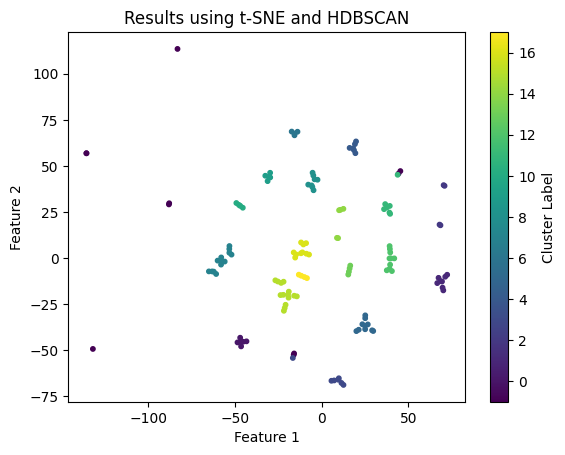

Distancia promedio: 69.11697387695312
Distancia mínima: 0.6500312089920044
Distancia máxima: 221.1998291015625
Silhouette Score: 0.6447526812553406
19


In [87]:
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=7)
cluster_labels = clusterer.fit_predict(embeddings_2d)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using t-SNE and HDBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')

# Calcular la distancia promedio entre todos los puntos en el espacio 2D
average_distance = np.mean(distances)

# Calcular la distancia mínima entre puntos
min_distance = np.min(distances[distances > 0])  # Excluyendo la diagonal (distancia de un punto consigo mismo)

# Calcular la distancia máxima entre puntos
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

# Evaluar la calidad del clustering
score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")
print(len(set(cluster_labels)))

https://factchecking.cl/user-review/la-propuesta-constitucional-reconoce-la-labor-de-cuidados-pero-no-la-garantiza-como-un-derecho-establecido/
https://factchecking.cl/user-review/la-constitucion-propuesta-garantiza-el-libre-e-igualitario-acceso-al-sistema-de-salud-pero-sera-la-legislacion-futura-la-que-definira-como/
https://factchecking.cl/user-review/la-propuesta-constitucional-garantiza-el-acceso-universal-a-la-educacion-pero-no-asegura-la-calidad-ni-buenos-empleos/
https://factchecking.cl/user-review/actualemtene-el-kinder-no-es-obligatorio-a-pesar-de-que-la-constitucion-asi-lo-dicta-desde-el-2013/
https://factchecking.cl/user-review/la-distribucion-de-poder-entre-minorias-y-mayorias-dependera-de-los-quorum-que-considere-una-eventual-nueva-constitucion/
https://factchecking.cl/user-review/el-trabajo-domestico-no-remunerado-es-una-actividad-economica-y-representa-el-256-del-pib-ampliado/
https://factchecking.cl/user-review/de-ganar-el-apruebo-futuro-de-los-ahorros-previsionales-dep

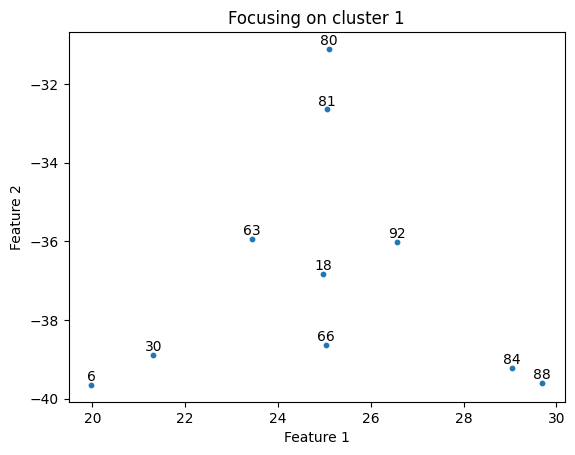

In [ ]:
# Focusing on cluster 1
cluster_to_print = 5
facts_selected = []
facts_labels = []

json_data = {}

with open("../fact_checking_data//fact_checking_data_extracted_linked.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  

for index, fact in enumerate(json_data["facts"]):
    if cluster_labels[index] == cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        print(json_data['facts'][index]['link'])


plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)
for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0,3), ha='center')

plt.title('Focusing on cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### 2.2.2 Modeling with BERT - UMAP 2D Visualization


c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


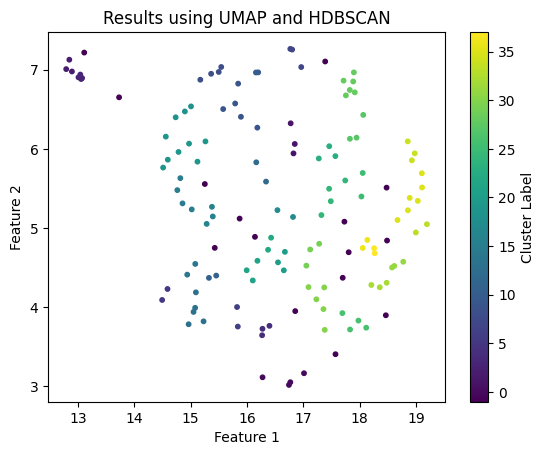

Distancia promedio: 2.431285858154297
Distancia mínima: 0.021541351452469826
Distancia máxima: 6.6979780197143555
Silhouette Score: 0.3521948754787445


In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, metric='euclidean')
embeddings_2d = umap_model.fit_transform(embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
cluster_labels = clusterer.fit_predict(embeddings_2d)

# Visualizar los resultados
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using UMAP and HDBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')

# Calcular la distancia promedio entre todos los puntos en el espacio 2D
average_distance = np.mean(distances)

# Calcular la distancia mínima entre puntos
min_distance = np.min(distances[distances > 0])  # Excluyendo la diagonal (distancia de un punto consigo mismo)

# Calcular la distancia máxima entre puntos
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

# Evaluar la calidad del clustering
score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

https://factchecking.cl/user-review/la-propuesta-de-nueva-constitucion-permite-que-prestadores-publicos-y-privados-formen-parte-del-sistema-de-salud/
https://factchecking.cl/user-review/el-derecho-de-propiedad-de-la-propuesta-constitucional-no-implica-el-fin-a-la-casa-propia/
https://factchecking.cl/user-review/constitucion-vigente-no-garantiza-derecho-a-la-vivienda-pero-tratados-internacionales-firmados-por-chile-si-lo-hacen/
https://factchecking.cl/user-review/propuesta-de-nueva-constitucion-incluye-el-reconocimiento-al-rol-fundamental-de-los-docentes-en-la-educacion/
https://factchecking.cl/user-review/el-derecho-a-la-vivienda-esta-consagrado-en-la-propuesta-de-nueva-constitucion-pero-esto-no-significa-que-las-casas-seran-del-estado/
https://factchecking.cl/user-review/la-herencia-de-los-ahorros-previsionales-dependera-de-la-ley-que-regule-el-sistema-de-pensiones-en-chile-luego-del-plebiscito/
https://factchecking.cl/user-review/no-existe-norma-que-establezca-que-con-el-derecho-a-la

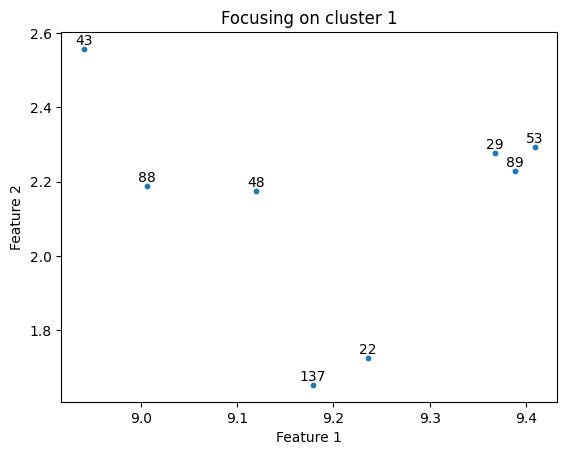

In [34]:
# Focusing on cluster 0
cluster_to_print = 0
facts_selected = []
facts_labels = []

json_data = {}

with open("../fact_checking_data//fact_checking_data_extracted_linked.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)  

for index, fact in enumerate(json_data["facts"]):
    if cluster_labels[index] == cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        print(json_data['facts'][index]['link'])


plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)
for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0,3), ha='center')

# for index, facts_labels in enumerate(facts_labels):
#     plt.text(23, -21 - 0.3*index, f"[{facts_labels}] {json_data['facts'][index]['link']}", fontsize=8)
# plt.gcf().set_size_inches(6, 6)
# plt.xlim(24, 32) 
# plt.ylim(-20, -12)
plt.title('Focusing on cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()